#### 1.Importing Dependencies

In [2]:
# Core
from pathlib import Path
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Image Processing
from PIL import Image

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

# Torchvision
import torchvision.transforms as transforms

# Metrics & Splitting
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

# Pretrained Models
import timm


# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


#### 2.PATH

In [3]:
images_root = Path(r"C:\Users\Nourhan Yehia\Desktop\Jupyter\Swin_Dogs_Project\images\Images")

#### 3. Initial Data Check

In [4]:
class_counts = {}
corrupted_images = []

for class_dir in images_root.iterdir():
    if class_dir.is_dir():
        class_name = class_dir.name
        class_counts[class_name] = 0

        for img_path in class_dir.iterdir():
            if img_path.is_file() and img_path.suffix.lower() in [".jpg", ".jpeg", ".png"]:
                try:
                    with Image.open(img_path) as img:
                        img.verify()
                    class_counts[class_name] += 1
                except Exception:
                    corrupted_images.append(str(img_path))

# Summary
num_classes = len(class_counts)
total_images = sum(class_counts.values())
counts = list(class_counts.values())

print("Number of classes:", num_classes)
print("Total valid images:", total_images)
print("Minimum images in a class:", min(counts))
print("Maximum images in a class:", max(counts))
print("Average images per class:", round(np.mean(counts), 2))
print("Number of corrupted images:", len(corrupted_images))


Number of classes: 120
Total valid images: 20580
Minimum images in a class: 148
Maximum images in a class: 252
Average images per class: 171.5
Number of corrupted images: 0


#### 4. Paths & Labels

In [5]:
class_names = sorted([p.name for p in images_root.iterdir() if p.is_dir()])
class_to_idx = {cls_name: i for i, cls_name in enumerate(class_names)}
idx_to_class = {i: cls_name for cls_name, i in class_to_idx.items()}

all_paths = []
all_labels = []

for cls_name in class_names:
    cls_dir = images_root / cls_name
    for img_path in cls_dir.iterdir():
        if img_path.is_file() and img_path.suffix.lower() in [".jpg", ".jpeg", ".png"]:
            all_paths.append(str(img_path))
            all_labels.append(class_to_idx[cls_name])

#### 5. Stratified Split 80/10/10

In [6]:
SEED = 42

train_paths, temp_paths, train_labels, temp_labels = train_test_split(
    all_paths,
    all_labels,
    test_size=0.20,
    random_state=SEED,
    stratify=all_labels
)

val_paths, test_paths, val_labels, test_labels = train_test_split(
    temp_paths,
    temp_labels,
    test_size=0.50,
    random_state=SEED,
    stratify=temp_labels
)

print("Train:", len(train_paths), "Val:", len(val_paths), "Test:", len(test_paths))


Train: 16464 Val: 2058 Test: 2058


In [7]:
from collections import Counter

print("Train class count (min/max):", min(Counter(train_labels).values()), max(Counter(train_labels).values()))
print("Val class count (min/max):",   min(Counter(val_labels).values()),   max(Counter(val_labels).values()))
print("Test class count (min/max):",  min(Counter(test_labels).values()),  max(Counter(test_labels).values()))


Train class count (min/max): 118 202
Val class count (min/max): 15 25
Test class count (min/max): 15 25


#### 6. Data Preprocessing (Transforms)


In [8]:
IMG_SIZE = 224

train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406),
                         std=(0.229, 0.224, 0.225)),
])

val_transforms = transforms.Compose([
    transforms.Resize(IMG_SIZE + 32),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406),
                         std=(0.229, 0.224, 0.225)),
])

test_transforms = val_transforms


#### 7. Dataset & DataLoaders


In [9]:
class DogsDataset(Dataset):
    def __init__(self, paths, labels, transform=None):
        self.paths = paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img_path = self.paths[idx]
        label = self.labels[idx]

        image = Image.open(img_path).convert("RGB")  
        if self.transform is not None:
            image = self.transform(image)

        return image, label


In [10]:
train_ds = DogsDataset(train_paths, train_labels, transform=train_transforms)

x, y = train_ds[0]
print("Image shape:", x.shape)
print("Label:", y)


Image shape: torch.Size([3, 224, 224])
Label: 0


 #### 8. Build DataLoaders

In [11]:
BATCH_SIZE = 32

train_ds = DogsDataset(train_paths, train_labels, transform=train_transforms)
val_ds   = DogsDataset(val_paths, val_labels, transform=val_transforms)
test_ds  = DogsDataset(test_paths, test_labels, transform=test_transforms)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=False)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=False)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=False)

print("Train batches:", len(train_loader))
print("Val batches:", len(val_loader))
print("Test batches:", len(test_loader))


Train batches: 515
Val batches: 65
Test batches: 65


#### 9. Model Development (Swin-Tiny)

In [12]:
import timm
import torch.nn as nn

NUM_CLASSES = 120

model = timm.create_model(
    "swin_tiny_patch4_window7_224",
    pretrained=True,
    num_classes=NUM_CLASSES
)

model = model.to(device)

print("Model created:", type(model).__name__)
print("Classifier head:", model.head)


Model created: SwinTransformer
Classifier head: ClassifierHead(
  (global_pool): SelectAdaptivePool2d(pool_type=avg, flatten=Identity())
  (drop): Dropout(p=0.0, inplace=False)
  (fc): Linear(in_features=768, out_features=120, bias=True)
  (flatten): Identity()
)


In [13]:
model.load_state_dict(torch.load("best_swin_tiny_headonly.pth", map_location=device))
print("Loaded best head-only checkpoint ")

Loaded best head-only checkpoint 


C:\Users\Nourhan Yehia\AppData\Local\Temp\ipykernel_37856\4547307.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_swin_tiny_headon

In [14]:
for p in model.parameters():
    p.requires_grad = False

for p in model.head.parameters():
    p.requires_grad = True

for p in model.layers[3].blocks[-1:].parameters():
    p.requires_grad = True

trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in model.parameters())
print("Trainable %:", 100 * trainable_params / total_params)


Trainable %: 26.01877165255776


#### 7. Loss & Optimizer

In [25]:
loss_fn = nn.CrossEntropyLoss()

optimizer = optim.AdamW(
    (p for p in model.parameters() if p.requires_grad),
    lr=5e-5,
    weight_decay=1e-4
)



#### 8.  Fine-Tuning (Head + Last Swin Block)

In [16]:
from tqdm import tqdm
import torch

def accuracy_from_logits(logits, y):
    preds = torch.argmax(logits, dim=1)
    return (preds == y).float().mean().item()

def run_one_epoch(model, loader, loss_fn, optimizer=None, device="cpu"):
    train_mode = optimizer is not None
    model.train() if train_mode else model.eval()

    running_loss = 0.0
    running_acc  = 0.0
    n_batches = len(loader)

    pbar = tqdm(loader, leave=False)
    for x, y in pbar:
        x, y = x.to(device), y.to(device)

        with torch.set_grad_enabled(train_mode):
            logits = model(x)
            loss = loss_fn(logits, y)
            acc = accuracy_from_logits(logits, y)

            if train_mode:
                optimizer.zero_grad(set_to_none=True)
                loss.backward()
                optimizer.step()

        running_loss += loss.item()
        running_acc  += acc
        pbar.set_postfix(loss=loss.item(), acc=acc)

    return running_loss / n_batches, running_acc / n_batches


EPOCHS = 2 

best_val_acc = 0.0
best_path = "best_swin_tiny_ft_lastblock.pth"

for epoch in range(1, EPOCHS + 1):
    train_loss, train_acc = run_one_epoch(model, train_loader, loss_fn, optimizer, device=device)
    val_loss, val_acc     = run_one_epoch(model, val_loader,   loss_fn, optimizer=None, device=device)

    print(f"Epoch {epoch:02d}/{EPOCHS} | "
          f"train loss {train_loss:.4f} acc {train_acc:.4f} | "
          f"val loss {val_loss:.4f} acc {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), best_path)
        print(f" Saved best model (val acc = {best_val_acc:.4f})")

print(" Best val acc:", best_val_acc)


Epoch 01/2 | train loss 0.2444 acc 0.9193 | val loss 0.2886 acc 0.9027
 Saved best model (val acc = 0.9027)


Epoch 02/2 | train loss 0.2072 acc 0.9311 | val loss 0.2951 acc 0.9051
 Saved best model (val acc = 0.9051)
 Best val acc: 0.9050961540295528


#### 8.1 Validation Evaluation

In [19]:
from sklearn.metrics import classification_report, confusion_matrix
model.load_state_dict(torch.load(best_path, map_location=device))
model.eval()

val_preds = []
val_labels = []

with torch.inference_mode():
    for x, y in val_loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        preds = torch.argmax(logits, dim=1)

        val_preds.extend(preds.cpu().numpy())
        val_labels.extend(y.cpu().numpy())

print("Validation Classification Report:\n")
print(classification_report(val_labels, val_preds, digits=4))


C:\Users\Nourhan Yehia\AppData\Local\Temp\ipykernel_37856\1058064980.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_path, map_loca

Validation Classification Report:

              precision    recall  f1-score   support

           0     0.8667    0.8667    0.8667        15
           1     0.9444    0.8947    0.9189        19
           2     0.9600    0.9600    0.9600        25
           3     0.9231    0.8000    0.8571        15
           4     0.7600    0.9048    0.8261        21
           5     0.9500    1.0000    0.9744        19
           6     0.9500    1.0000    0.9744        19
           7     1.0000    0.8235    0.9032        17
           8     0.7895    0.8824    0.8333        17
           9     1.0000    1.0000    1.0000        24
          10     0.9412    0.8889    0.9143        18
          11     0.8947    0.8947    0.8947        19
          12     0.9474    0.9474    0.9474        19
          13     0.9444    1.0000    0.9714        17
          14     0.8421    1.0000    0.9143        16
          15     0.8182    0.6000    0.6923        15
          16     0.6500    0.8125    0.7222   

 #### 9. Model Evaluation  

In [20]:
import torch
from sklearn.metrics import classification_report, confusion_matrix

model.load_state_dict(torch.load("best_swin_tiny_ft_lastblock.pth", map_location=device))
model.eval()

test_loss, test_acc = run_one_epoch(model, test_loader, loss_fn, optimizer=None, device=device)
print(f"TEST | loss {test_loss:.4f} acc {test_acc:.4f}")

all_preds = []
all_labels = []

with torch.inference_mode():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        preds = torch.argmax(logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

target_names = [idx_to_class[i] for i in range(NUM_CLASSES)]
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=target_names, digits=4))


C:\Users\Nourhan Yehia\AppData\Local\Temp\ipykernel_37856\630126525.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_swin_tiny_ft_l

TEST | loss 0.2153 acc 0.9298

Classification Report:
                                          precision    recall  f1-score   support

                     n02085620-Chihuahua     0.9375    1.0000    0.9677        15
              n02085782-Japanese_spaniel     0.9444    0.9444    0.9444        18
                   n02085936-Maltese_dog     0.8571    0.9600    0.9057        25
                      n02086079-Pekinese     1.0000    0.8000    0.8889        15
                      n02086240-Shih-Tzu     0.8077    0.9545    0.8750        22
              n02086646-Blenheim_spaniel     1.0000    1.0000    1.0000        19
                      n02086910-papillon     1.0000    1.0000    1.0000        20
                   n02087046-toy_terrier     1.0000    0.9412    0.9697        17
           n02087394-Rhodesian_ridgeback     0.8750    0.7778    0.8235        18
                  n02088094-Afghan_hound     1.0000    1.0000    1.0000        24
                        n02088238-basset   

#### 10.Real-Time Testing

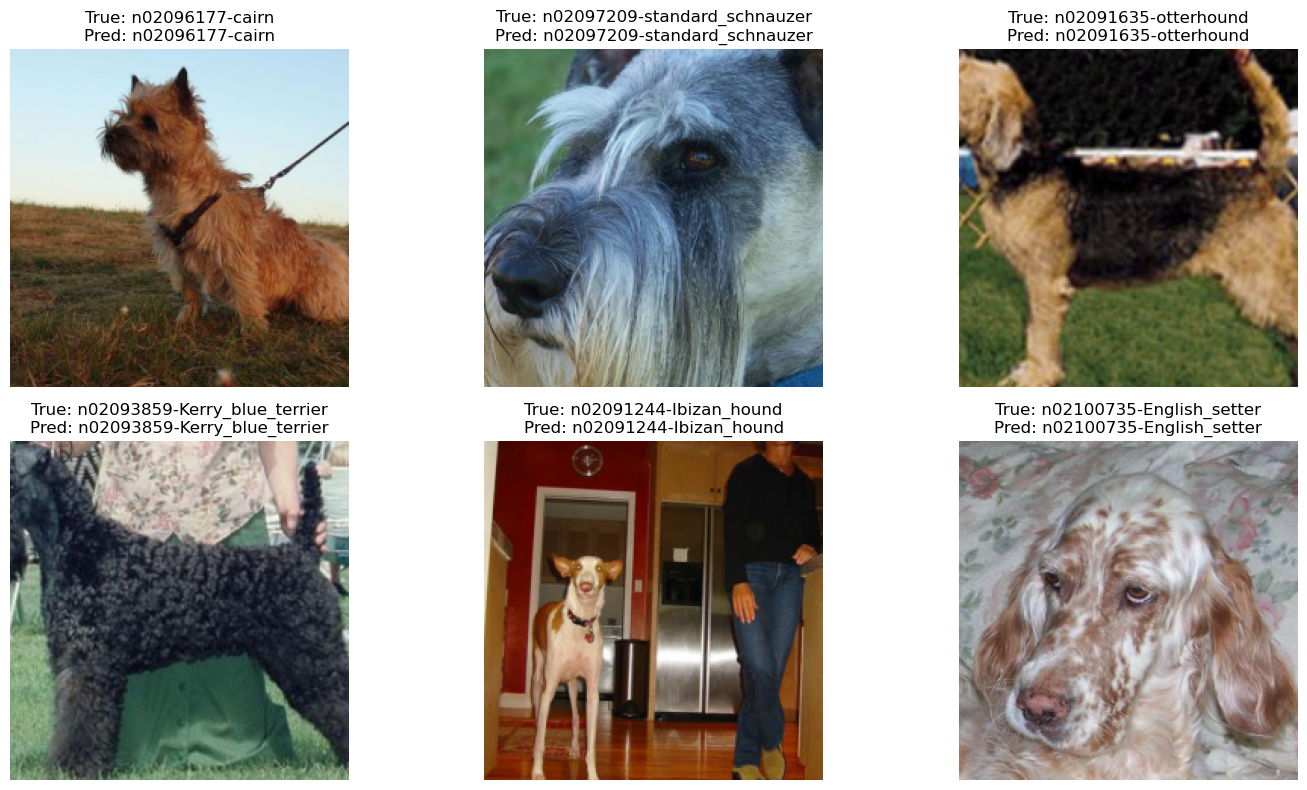

In [22]:
import matplotlib.pyplot as plt
import random
import torch

def denormalize(img):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
    img = img * std + mean
    return torch.clamp(img, 0, 1)

model.eval()

num_samples = 6
indices = random.sample(range(len(test_ds)), num_samples)

plt.figure(figsize=(15, 8))

for i, idx in enumerate(indices):
    image, label = test_ds[idx]

    with torch.inference_mode():
        output = model(image.unsqueeze(0).to(device))
        pred = torch.argmax(output, dim=1).item()

    image_display = denormalize(image)

    plt.subplot(2, 3, i + 1)
    plt.imshow(image_display.permute(1, 2, 0))
    plt.title(f"True: {idx_to_class[label]}\nPred: {idx_to_class[pred]}")
    plt.axis("off")

plt.tight_layout()
plt.show()



#### 11.Handling Complex Scenarios

In [24]:
counts = Counter(all_labels)
min_c = min(counts.values())
max_c = max(counts.values())

print("Min images/class:", min_c)
print("Max images/class:", max_c)
print("Imbalance ratio (max/min):", round(max_c / min_c, 2))


Min images/class: 15
Max images/class: 25
Imbalance ratio (max/min): 1.67


#### 1-Class Imbalance Analysis:

#### •To investigate potential class imbalance, we analyzed the distribution of images across all 120 dog breeds.

#### •The dataset shows a relatively balanced distribution of samples per class, with only minor differences between the smallest and largest classes.

#### •The imbalance ratio (max/min samples per class) is low, indicating that severe class imbalance is not a major issue in this dataset.

#### •Because of this balanced distribution:

#### -No aggressive imbalance-handling techniques were required.

#### -However, class weighting in the loss function remains a valid strategy if imbalance becomes significant in future experiments.





#### 2-Fine-Tuning Strategy for Pre-trained Model:

#### •To effectively fine-tune the pre-trained Swin Transformer model while avoiding overfitting, a staged fine-tuning strategy was applied:

#### -The model was initialized with ImageNet pre-trained weights.

#### -The classification head was adapted to match the 120 dog breeds.

#### -Instead of training the full network at once, only the classification head and the last transformer block were unfrozen.

#### •A smaller learning rate was used during fine-tuning to prevent large destructive updates to pre-trained weights.
